In [83]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'
from multiprocessing import Pool

# -------------------------------- parameters ---------------------------------------
gt_seg = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
gt_aff = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_aff.h5'
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
# pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'

out_folder = '/nobackup/turaga/singhc/par_zwshed_3/'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 16
MAX_LEN = 200

# -------------------------------- load data ---------------------------------------
f = h5py.File(pred_file, 'r')
preds = np.array(f['main']).astype('float32')
g = h5py.File(gt_seg,'r')
gt_seg = g['main']
print preds.shape

(3, 432, 432, 432)


# Divide Volumes, set up args

In [84]:
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'_vll/'
dims = np.array(preds.shape[1:])
print "dims",dims # x,y,z
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
# num_vols[0] = 2 # delete this!
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts,ends = [],[]
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas - [3,3,3] +3*np.array([x==0,y==0,z==0]))
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra +[3,3,3])
args = []
for i in range(len(starts)):
    s,e = starts[i],ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print i,s,e,pred_vol.shape
    args.append((pred_vol,out_folder+dim_to_name(s)))    

dims [432 432 432]
num_vols [3 3 3]
deltas [144 144 144]
0 [0 0 0] [148 148 148] (3, 148, 148, 148)
1 [  0   0 141] [148 148 292] (3, 148, 148, 151)
2 [  0   0 285] [148 148 439] (3, 148, 148, 147)
3 [  0 141   0] [148 292 148] (3, 148, 151, 148)
4 [  0 141 141] [148 292 292] (3, 148, 151, 151)
5 [  0 141 285] [148 292 439] (3, 148, 151, 147)
6 [  0 285   0] [148 439 148] (3, 148, 147, 148)
7 [  0 285 141] [148 439 292] (3, 148, 147, 151)
8 [  0 285 285] [148 439 439] (3, 148, 147, 147)
9 [141   0   0] [292 148 148] (3, 151, 148, 148)
10 [141   0 141] [292 148 292] (3, 151, 148, 151)
11 [141   0 285] [292 148 439] (3, 151, 148, 147)
12 [141 141   0] [292 292 148] (3, 151, 151, 148)
13 [141 141 141] [292 292 292] (3, 151, 151, 151)
14 [141 141 285] [292 292 439] (3, 151, 151, 147)
15 [141 285   0] [292 439 148] (3, 151, 147, 148)
16 [141 285 141] [292 439 292] (3, 151, 147, 151)
17 [141 285 285] [292 439 439] (3, 151, 147, 147)
18 [285   0   0] [439 148 148] (3, 147, 148, 148)
19 [285  

# Call Watershed

In [85]:
def zwshed_h5_par(arg):
    (pred_vol,seg_save_path) = arg
    zwatershed_basic_h5(pred_vol,seg_save_path)
    print "finished",seg_save_path,"watershed"
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)
# zwshed_h5_par(args[0])

finished /nobackup/turaga/singhc/par_zwshed_3/0_0_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_0_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_0_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_141_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_285_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_141_0_vll/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_141_141_vll/ watershed
finished /nobackup

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Stitch

i,x,y,z 0 0 0 0
re len 0 counts len 0
i,x,y,z 1 0 0 1
re len

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


 183 counts len 212
re len 2 183 counts len 212
	merging numbers, 183 keys ... 
	before nsegs= 26638 num0= 74275701
	after nsegs= 26604 num0= 74275701


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


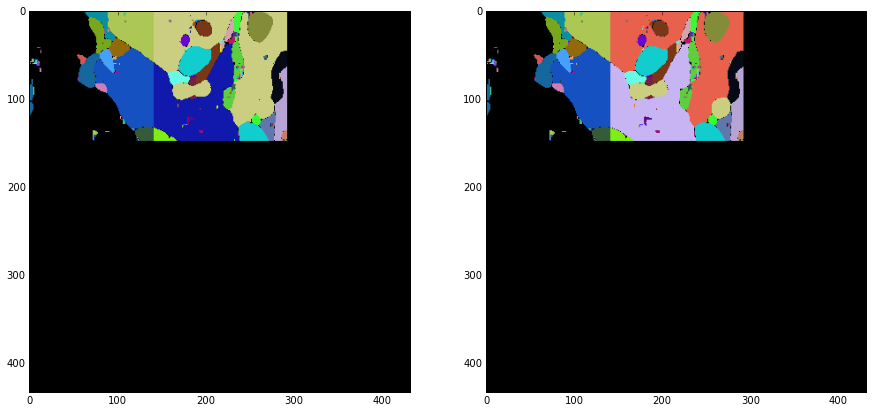

merging rgs...
	renumbering all... 26604 num0= 74275701


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


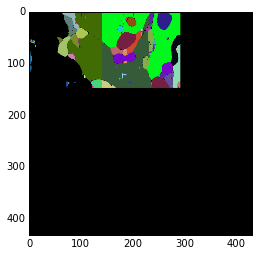

finishedd


In [257]:
# todo - have this support several threshes - for filename in os.listdir(arg[2]):
COUNT_THRESH = 0
filename = 'basic.h5'
seg_out = np.zeros(dims,dtype='uint64')
rg_full = np.empty((0,3))
X,Y,Z = (1,1,2)
x_range,y_range,z_range = [],[],[]
re = {}
counts = {}
for x in range(X): #num_vols[0]):
    ix = x*num_vols[1]*num_vols[2]
    sx,ex,re_x = starts[ix],ends[ix],{}
    
    # start ybar --------------------------------------------------
    xdim = deltas[0]+7
    if x==0:
        xdim = deltas[0]+4
    if x==num_vols[0]-1:
        xdim = dims[0]-deltas[0]*(num_vols[0]-1)
    ybar = np.zeros((xdim,dims[1],dims[2]),dtype='uint64')

    for y in range(Y): #num_vols[1]):
        iy = x*num_vols[1]*num_vols[2]+y*num_vols[2]
        sy,ey = starts[iy], ends[iy]
        
        # start zbar -----------------------------------------------
        ydim = deltas[1]+7
        if y==0:
            ydim = deltas[1]+4
        if y==num_vols[1]-1:
            ydim = dims[1]-deltas[1]*(num_vols[1]-1)
        zbar = np.zeros((xdim,ydim,dims[2]),dtype='uint64')
        
        for z in range(Z): #num_vols[2]): 
            i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
            arg,s,e = args[i],starts[i],ends[i]
            basic_file = h5py.File(arg[1]+filename,'r')
            seg = np.array(basic_file['seg'])
            rg = np.array(basic_file['rg'])
            inc = np.max(zbar)+1
            seg[seg!=0]+=inc
            rg[:,:2] += inc
            print "i,x,y,z",i,x,y,z
            if not z==0: 
                re,counts = calc_renums(edge_mins=zbar[:,:,s[2]+3],edge_maxes=seg[:,:,3], re=re, counts=counts)
            zbar[:,:,s[2]:e[2]] = seg[:,:,:]
            print "re len",len(re), "counts len",len(counts)
#         zbar,rg_full = merge_and_renum(re,zbar,rg_full,p=False,counts=counts)
        zbar[zbar!=0] += np.max(ybar)+1
        # end zbar --------------------------------------------------    
        
        if not y==0: 
            re,counts = calc_renums(edge_mins=ybar[0:,s[1]+3,:],edge_maxes=zbar[0:,3,:], re=re, counts=counts)
        ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]

#     ybar,rg_fulls = merge_and_renum(re,ybar,rg_full,p=True,counts=counts_y)
    ybar[ybar!=0] += np.max(seg_out)+1

    # end ybar -------------------------------------------------------
    if not x==0:
        re,counts = calc_renums(edge_mins=seg_out[sx[0]+3,:,:],edge_maxes=ybar[3,:,:],re=re, counts=counts)
    seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]
    print "re len 2",len(re), "counts len",len(counts)
    seg_out,rg_full = merge_and_renum(re,seg_out,rg_full,p=True,counts=counts)

    # recalculate counts
    
    
print "finishedd"
# display_seg_xy(seg_out)

i,x,y,z 0 0 0 0
re len 0 counts len 0
i,x,y,z 1 0 0 1
re len 183 counts len 212
i,x,y,z 3 0 1 0
re len 616 counts len 685
i,x,y,z 4 0 1 1
re len 1322 counts len 1430
i,x,y,z 9 1 0 0
re len 1804 counts len 1966
i,x,y,z 10 1 0 1
re len 2868 counts len 3095
i,x,y,z 12 1 1 0
re len 3610 counts len 3913
i,x,y,z 13 1 1 1
re len 4675 counts len 5139
filter merges...
	merging numbers, 4675 keys ... 
82966 9
89993 43729
89996 43732
89997 43733
43733 10354
89999 43734
43734 10355
90000 43735
43735 10356
90005 43739
72110 1864
80572 33948
33948 5080
51010 17100
89995 43731
34531 5196
84967 9687
90084 43955
4748 4747
50619 39278
39278 75
12813 10561
10561 7258
85766 7571
7571 7247
143498 50937
80572 33948
33948 5080
72089 19
47640 11765
84967 9687
84967 9687
51010 17100
143555 96151
96151 94337
124272 72089
72089 19
40429 77
86689 6850
124272 72089
72089 19
49958 49534
40386 10333
43254 43049
43049 41926
41926 40080
49890 49300
50062 49300
32018 1864
63635 19261
90435 47640
47640 11765
33948 5080


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


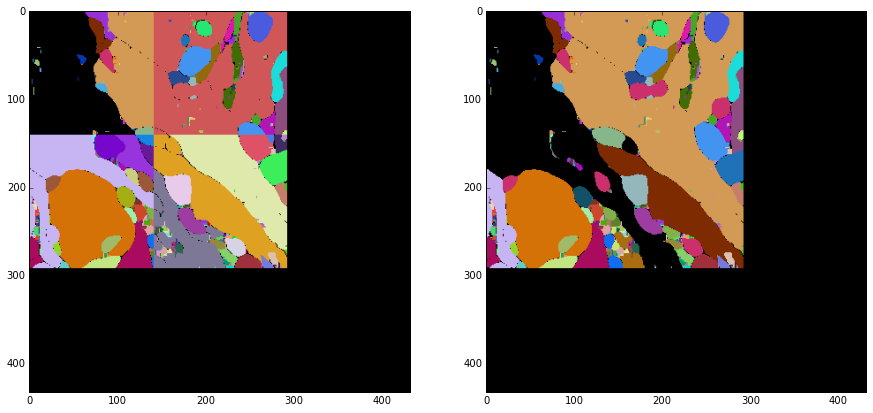

merging rgs...
	renumbering all... 154050 num0= 55922726


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


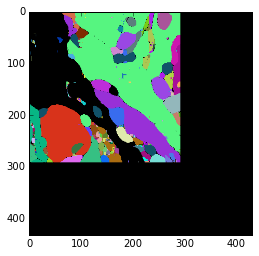

'            \n#         zbar,rg_full = merge_and_renum(re,zbar,rg_full,p=False,counts=counts)\n#         zbar[zbar!=0] += np.max(ybar)+1\n        # end zbar --------------------------------------------------    \n        \n        if not y==0: \n            re,counts = calc_renums(edge_mins=ybar[0:,s[1]+3,:],edge_maxes=zbar[0:,3,:], re=re, counts=counts)\n        ybar[:,sy[1]:ey[1],:] = zbar[:,:,:]\n\n#     ybar,rg_fulls = merge_and_renum(re,ybar,rg_full,p=True,counts=counts_y)\n#     ybar[ybar!=0] += np.max(seg_out)+1\n\n    # end ybar -------------------------------------------------------\n    if not x==0:\n        re,counts = calc_renums(edge_mins=seg_out[sx[0]+3,:,:],edge_maxes=ybar[3,:,:],re=re, counts=counts)\n    seg_out[sx[0]:ex[0],:,:] = ybar[:,:,:]\n    print "re len 2",len(re), "counts len",len(counts)\n    seg_out,rg_full = merge_and_renum(re,seg_out,rg_full,p=True,counts=counts)\n\n    # recalculate counts\n    \n    \nprint "finishedd"\n# display_seg_xy(seg_out)\n'

In [284]:
# todo - have this support several threshes - for filename in os.listdir(arg[2]):
COUNT_THRESH = 0
filename = 'basic.h5'
seg_out = np.zeros(dims,dtype='uint64')
rg_full = np.empty((0,3))
X,Y,Z = (2,2,2)
x_range,y_range,z_range = [],[],[]
re = {}
counts = {}
for x in range(X): #num_vols[0]):
    ix = x*num_vols[1]*num_vols[2]
    sx,ex,re_x = starts[ix],ends[ix],{}
    
    # start ybar --------------------------------------------------
    xdim = deltas[0]+7
    if x==0:
        xdim = deltas[0]+4
    if x==num_vols[0]-1:
        xdim = dims[0]-deltas[0]*(num_vols[0]-1)
    ybar = np.zeros((xdim,dims[1],dims[2]),dtype='uint64')

    for y in range(Y): #num_vols[1]):        
        for z in range(Z): #num_vols[2]): 
            i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
            arg,s,e = args[i],starts[i],ends[i]
            basic_file = h5py.File(arg[1]+filename,'r')
            seg = np.array(basic_file['seg'])
            rg = np.array(basic_file['rg'])
            inc = np.max(seg_out)+1
            seg[seg!=0]+=inc
            rg[:,:2] += inc
            print "i,x,y,z",i,x,y,z
            if not z==0: 
                re,counts = calc_renums(edge_mins=seg_out[s[0]:e[0],s[1]:e[1],s[2]+3],edge_maxes=seg[:,:,3], re=re, counts=counts)
            if not y==0:
                re,counts = calc_renums(edge_mins=seg_out[s[0]:e[0],s[1]+3,s[2]:e[2]],edge_maxes=seg[:,3,:],re=re,counts=counts)
            if not x==0:
                re,counts = calc_renums(edge_mins=seg_out[sx[0]+3,s[1]:e[1],s[2]:e[2]],edge_maxes=seg[3,:,:],re=re, counts=counts)
            seg_out[s[0]:e[0],s[1]:e[1],s[2]:e[2]] = seg[:,:,:]
            print "re len",len(re), "counts len",len(counts)
            
merges_filtered = filter_merges(re,counts)            
seg_out,rg_full = merge_and_renum(merges_filtered,seg_out,rg_full,p=True)

# recalculate counts
    
    
print "finishedd"
# display_seg_xy(seg_out)
'''

In [285]:
# stitch methods
def calc_renums(edge_mins,edge_maxes, re, counts={}):
    edge_mins = edge_mins.ravel()
    edge_maxes = edge_maxes.ravel()
#     print "edge_mins",edge_mins
#     print "edge_maxes",edge_maxes
    for j in range(len(edge_mins)):
        edge_min = edge_mins[j]
        edge_max = edge_maxes[j]
        if not edge_min==0 and not edge_max==0:
            if not edge_max==edge_min:
                if edge_max in re: # already in map
                    old_min = re[edge_max]
                    merge_max = max(old_min,edge_min)
                    merge_min = min(old_min,edge_min)
                    if not merge_max==merge_min:
                        re[merge_max] = merge_min
                        add_or_inc(merge_max,merge_min,counts)
            re[edge_max] = edge_min
            add_or_inc(edge_max,edge_min,counts)
    return re, counts
    
def prune_and_renum(seg,sizeThreshold=1):
    segId = np.unique(seg)
    renum = np.zeros(segId.max()+1,dtype=np.uint64)
    renum[segId] = np.arange(1,len(segId)+1)
    renum[0]=0
    return renum[seg]

def add_or_inc(key_max,key_min,d):
    key = (key_max,key_min)
    if not key in d:
        d[key] = 1
    else:
        d[key] +=1
    
def filter_merges(renums,counts):
    print "\tfilter merges..."
    # only keep strongest edges
    renums = {}
    count_maxes = {}
    for pair in counts:
        count = counts[pair]
        e1,e2 = pair
        if e1 in renums:
            if count > count_maxes[e1]:
                renums[e1] = e2
                count_maxes[e1] = count
        else:
            renums[e1] = e2
            count_maxes[e1] = count
    
    # calculate merges
    sum_counts = 0
    for key in counts:
        sum_counts += counts[key]
    renums2 = {}
    print "\tmerging numbers,",len(renums.keys()),"keys ... "            
    for key in renums:
        val = renums[key]
        if counts[(key,val)] > COUNT_THRESH:
            while val in renums:
                val = renums[val]
            renums2[key] = val
    return renums2
    
def merge_and_renum(renums2,zbar,rg_full,p=False):
            
    # merge segs
    print "\tbefore nsegs=",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        fig = plt.figure(figsize=(15, 7))
        plt.subplot(1,2,1)
        plt.imshow(zbar[0, :, :], cmap=cmap)
    mp = np.arange(0,np.max(zbar)+1,dtype='uint64')
    mp[renums2.keys()] = renums2.values()
    zbar = mp[zbar]
    print "\tafter nsegs=",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        plt.subplot(1,2,2)
        plt.imshow(zbar[0, :, :], cmap=cmap)
    plt.show()
    
    # merge rg
    print "merging rgs..." 
    
    # renumber
    zbar = prune_and_renum(zbar,2)
    print "\trenumbering all...",len(np.unique(zbar)),"num0=",np.sum(zbar==0)
    if p:
        plt.imshow(zbar[0, :, :], cmap=cmap)
    plt.show()

    return zbar, rg_full

# Visualize

In [116]:
def display_affs(raw):
    plt.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    plt.show()
def display_seg_yz(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(raw[depth, :, :], cmap=cmap)
    plt.show()
def display_seg_xy(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[:, :, depth], cmap=cmap)
    plt.show()

In [201]:
x = np.array([[1,2,3],[4,5,6],[7,8,9]])
y = np.arange(1,10)
x2 = np.delete(x,1,0)
y2 = np.delete(y,5)
print x
print x2
print y
print y2

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 2 3]
 [7 8 9]]
[1 2 3 4 5 6 7 8 9]
[1 2 3 4 5 7 8 9]


In [225]:
mp = np.arange(0,np.max(zbar)+1,dtype='uint64')
rg_ = rg_fulls[0]
x = rg_[:,:2].astype('int')
print x.shape
print mp.shape
print mp[x]
rg_[:,:2] = mp[x]

# rg_[:,:2] = mp[rg_[:,:,2]]

(63108, 2)
(27121,)
[[12742 12742]
 [12613 12613]
 [12565 12565]
 ..., 
 [10333 12739]
 [  102  3492]
 [  208  7720]]


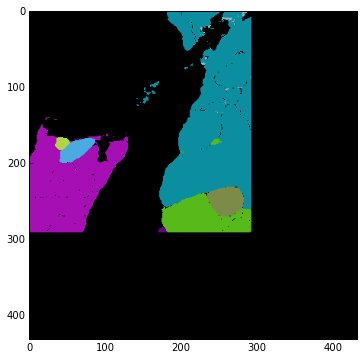

In [287]:
display_seg_xy(seg_out)